In [1]:
import ee
import geemap
import geemap.foliumap as geefolium
import folium
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
OUTDIR = Path("ee_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

In [3]:
EE_PROJECT = "ee-bastolashristi"

In [4]:
try:
    if EE_PROJECT:
        ee.Initialize(project = EE_PROJECT)
    else:
        ee.Initialize()
except Exception:
    ee.Authenticate()
    if EE_PROJECT:
        ee.Initialize(project = EE_PROJECT)
    else:
        ee.Initialize()

In [5]:
connectivity_test = ee.Number(1).add(2).getInfo()
print("connectivity_test:", connectivity_test)

connectivity_test: 3


In [6]:
xmin, ymin = 85.1887289999999808, 27.5700319999999763
xmax, ymax = 85.5659219999999863, 27.8172329999999732

region = ee.Geometry.Polygon([[
    [xmin, ymin], [xmin, ymax],
    [xmax, ymax], [xmax, ymin]
]])

In [7]:
#Section 4: Satellite Embeddings Data Acquisition
embeddings_ic = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL") \
    .filterDate("2024-01-01", "2025-01-01") \
    .filterBounds(region)
embeddings_image = embeddings_ic.mosaic().clip(region).toFloat()

In [8]:
#Section 5: Training Data Generation for clustering
n_samples = 1000
training = embeddings_image.sample(
    region=region, scale = 10, numPixels = n_samples,
    seed = 0, geometries = False
)

In [9]:
# Section 6: K-means Clustering Function
def get_clusters(n_clusters:int) -> ee.Image:
  clusterer = ee.Clusterer.wekaKMeans(nClusters=int(n_clusters)).train(training)
  clustered = embeddings_image.cluster(clusterer)
  return clustered
clustered_k5 = get_clusters(5)

In [10]:
#section 7-8: Interactive visualization (saved to HTML)
# Kelly's 22 colors (distinct). Use first N for discrete classes.
kelly22 = [
    "#F3C300", "#875692", "#F38400", "#A1CAF1", "#BE0032", "#C2B280", "#848482", "#008856",
    "#E68FAC", "#0067A5", "#F99379", "#604E97", "#F6A600", "#B3446C", "#DCD300", "#882D17",
    "#80B600", "#654522", "#E25822", "#2B3D26", "#F2F3F4", "#222222"
]
vis_k5 = dict(min = 0, max = 4, palette = kelly22[:5])
m = geefolium.Map(location = [ymin, xmin], zoom_start = 13, control_scale = True)
m.add_basemap("SATELLITE")
m.addLayer(clustered_k5.toInt(), vis_k5, "k=5 clusters")
m.fit_bounds([[ymin, xmin]], [[ymax, xmax]])
map_path = OUTDIR / "map_kp.html"
m.save(str(map_path))

In [11]:
# section 9-10: Export k = 3,5, 10 locally (GeoTiff)
def export_cluster_local(k: int, outdir: Path = OUTDIR):
  img = get_clusters(k).toInt().clip(region)
  tif = outdir / f"clusters_k{k}.tif"
  geemap.ee_export_image(img, str(tif), scale = 30, region= region, file_per_band= False)
  return(tif)
cluster_values = [3,5,10]
cluster_paths = [export_cluster_local(k) for k in cluster_values]

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Dell\OneDrive\Desktop\Data science practice\ee_outputs\clusters_k3.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Dell\OneDrive\Desktop\Data science practice\ee_outputs\clusters_k5.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Dell\OneDrive\Desktop\Data science practice\ee_outputs\clusters_k10.tif


In [12]:
# section 12: Multi-panel Visualization of clusters
def read_single_band(path:Path):
  with rasterio.open(path) as src:
    arr = src.read(1)
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    transform = src.transform
    crs = src.crs
  return arr, extent, transform, crs
arr5, extent5, transform5, crs5 = read_single_band(OUTDIR / "clusters_k5.tif")
arr3, _, _, _ = read_single_band(OUTDIR / "clusters_k3.tif")
arr10, _, _, _ = read_single_band(OUTDIR / "clusters_k10.tif")

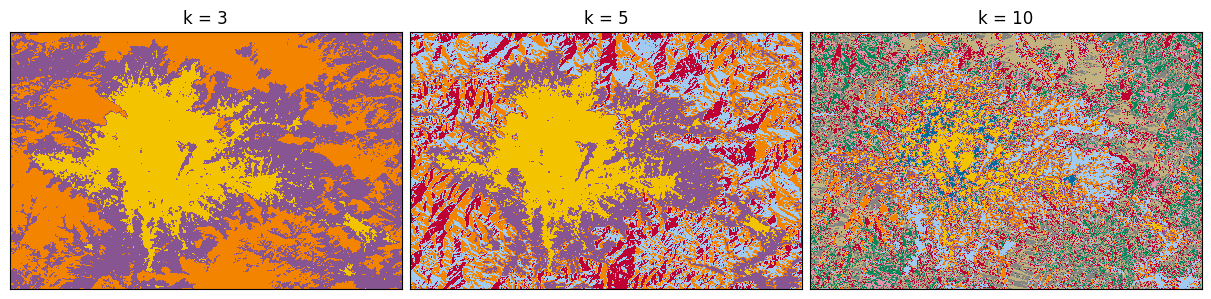

In [13]:
fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
for ax, (arr, title, k) in zip(
    axs,
    [(arr3, "k = 3", 3), (arr5, "k = 5", 5), (arr10, "k = 10", 10)]
):
    from matplotlib.colors import ListedColormap, BoundaryNorm
    cmap = ListedColormap(kelly22[:k])
    bounds = np.arange(-0.5, k + 0.5, 1)
    norm = BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(arr, cmap=cmap, norm=norm)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
panel_png = OUTDIR / "clusters_panel.png"
plt.savefig(panel_png, dpi = 300, bbox_inches = "tight")
plt.show()

In [14]:
# part 2:  Change detection analysis(computed server side in EE)
# Section 13-14: Multi-temporal Data + Exports (local)
def get_satellite_embeddings(y0:int, y1: int) -> ee.Image:
  return(ee.ImageCollection ("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
          .filterDate(f"{y0}-01-01", f"{y1}-01-01")
          .filterBounds(region)
          .mosaic()
          .clip(region)
          .toFloat()
  )
emb_2018 = get_satellite_embeddings(2018, 2019)
emb_2024 = get_satellite_embeddings(2024, 2025)

In [15]:
mad_img = emb_2024.subtract(emb_2018).abs().reduce(ee.Reducer.mean())
mad_tif = OUTDIR / "mean_absolute_difference.tif"
geemap.ee_export_image(mad_img, filename=str(mad_tif), scale=30, region=region)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Dell\OneDrive\Desktop\Data science practice\ee_outputs\mean_absolute_difference.tif


In [16]:
# Cosine similarity across 64-D embeddings (single-band image)
a = emb_2018.toArray()
b = emb_2024.toArray()

#dot(a,b)
dot = a.multiply(b).arrayReduce(ee.Reducer.sum(), [0]).arrayGet([0])
na = a.multiply(a).arrayReduce(ee.Reducer.sum(), [0]).arrayGet([0]).sqrt()
nb = a.multiply(b).arrayReduce(ee.Reducer.sum(), [0]).arrayGet([0]).sqrt()

#Avoid divide-by-zero, clamp to [-1, 1], and name the band
den = na.multiply(nb)
cos = dot.divide(den).clamp(-1,1).updateMask(den.neq(0)).rename('cosine')

#Export (use positional args or ee_image= depending on your geemap version)
cos_tif = OUTDIR / "cosine_2018_2024.tif"
geemap.ee_export_image(cos, str(cos_tif), scale = 30, region=region)


Generating URL ...
Please wait ...
Data downloaded to C:\Users\Dell\OneDrive\Desktop\Data science practice\ee_outputs\cosine_2018_2024.tif


In [17]:
# section 16 and 18: Local visualization of change maps
def plot_single_band_tif(
        tif_path: Path, title: str, cmap="magma",
        vmin=None, vmax=None, outfile: Path = None
):
    with rasterio.open(tif_path) as src:
      arr = src.read(1)
      extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    fig = plt.figure(figsize=(7.5, 6))
    plt.imshow(arr, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xticks([]), plt.yticks([])
    cbar = plt.colorbar()
    if outfile is not None:
      plt.savefig(outfile, dpi=600, bbox_inches="tight")
    if show:
        plt.show()    

In [18]:
def plot_single_band_tif(tif_path: Path, title: str, cmap="magma", show=True, outfile: Path = None):
    import numpy as np
    import matplotlib.pyplot as plt
    import rasterio

    with rasterio.open(tif_path) as src:
        arr = src.read(1)  # read first band
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Replace masked/nan values with 0 (optional)
    arr = np.nan_to_num(arr)

    plt.figure(figsize=(8, 6))
    plt.imshow(arr, cmap=cmap, extent=extent, origin='upper')
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Value")

    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches="tight")
        print(f"Saved figure: {outfile}")

    if show:
        plt.show()


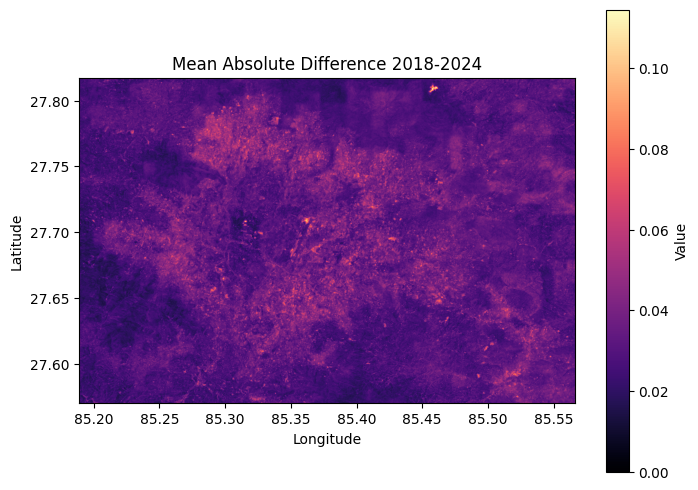

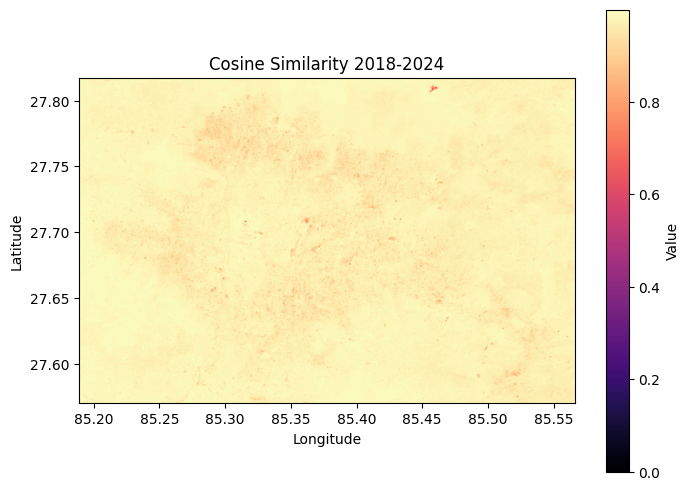

In [19]:
plot_single_band_tif(OUTDIR/"mean_absolute_difference.tif", "Mean Absolute Difference 2018-2024")
plot_single_band_tif(OUTDIR/"cosine_2018_2024.tif", "Cosine Similarity 2018-2024")

In [20]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUTDIR = Path("ee_outputs")

# List of TIFFs to convert
tif_files = [
    "mean_absolute_difference.tif",
    "cosine_2018_2024.tif"
]

for tif_name in tif_files:
    tif_path = OUTDIR / tif_name
    png_path = OUTDIR / f"{tif_name.replace('.tif', '.png')}"

    # Read TIFF
    with rasterio.open(tif_path) as src:
        arr = src.read(1)
        arr = np.nan_to_num(arr)  # replace NaN with 0
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Plot and save as PNG
    plt.figure(figsize=(8,6))
    plt.imshow(arr, cmap="magma", extent=extent, origin='upper')
    plt.title(tif_name.replace(".tif",""))
    plt.colorbar(label="Value")
    plt.xticks([]); plt.yticks([])
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"Saved PNG: {png_path}")


Saved PNG: ee_outputs\mean_absolute_difference.png
Saved PNG: ee_outputs\cosine_2018_2024.png


In [24]:
# === LABELS FOR EACH CLUSTER VALUE ===

labels_k3 = {
    0: "Built-up",
    1: "Vegetation",
    2: "Bare Land"
}

labels_k5 = {
    0: "Built-up",
    1: "Vegetation",
    2: "Sparse Vegetation",
    3: "Bare Rock",
    4: "Agriculture"
}

labels_k10 = {
    0: "Dense Urban",
    1: "Sparse Urban",
    2: "Forest",
    3: "Agriculture",
    4: "Bare Rock",
    5: "Grassland",
    6: "Shrubland",
    7: "Snow",
    8: "Wet Areas",
    9: "Mixed Vegetation"
}


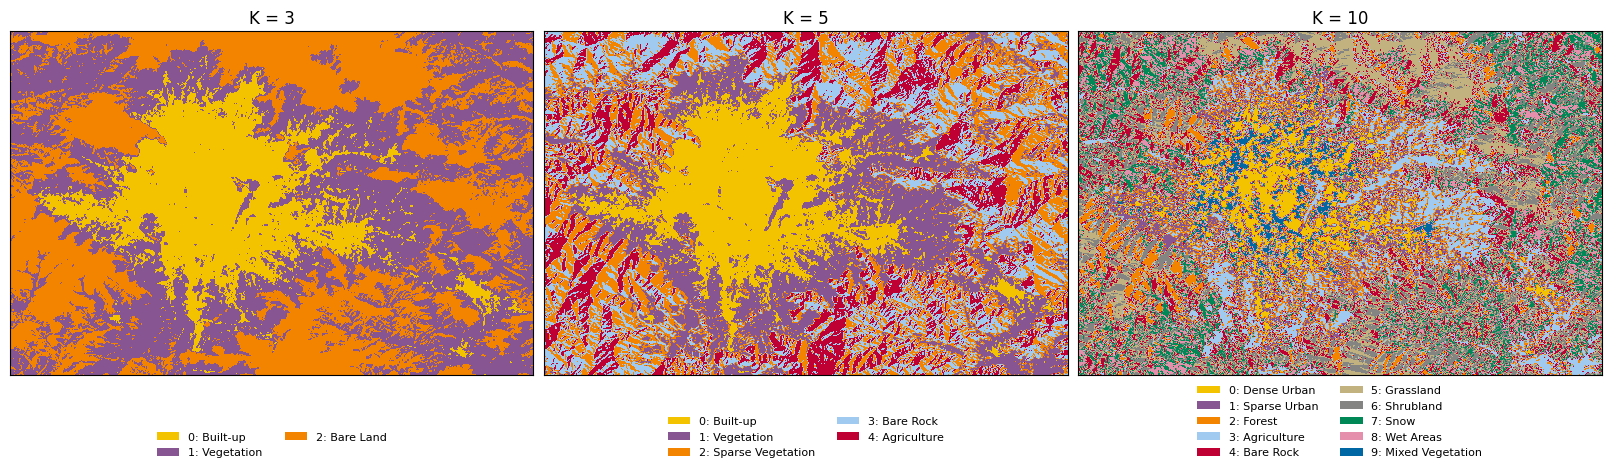

In [29]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

def plot_clusters_with_legend(arr, k, labels_dict, title, ax):
    
    cmap = ListedColormap(kelly22[:k])
    bounds = np.arange(-0.5, k + 0.5, 1)
    norm = BoundaryNorm(bounds, cmap.N)

    im = ax.imshow(arr, cmap=cmap, norm=norm)
    ax.set_title(title, fontsize=12)
    ax.set_xticks([]); ax.set_yticks([])

    # --- Build legend items ---
    legend_elements = []
    for cluster_id in range(k):
        color = cmap(cluster_id)
        label = labels_dict.get(cluster_id, f"Class {cluster_id}")
        legend_elements.append(Patch(facecolor=color, label=f"{cluster_id}: {label}"))

    ax.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.27),
        fontsize=8,
        ncol=2,
        frameon=False
    )


# === LOAD IMAGES ===
arr5, extent5, transform5, crs5 = read_single_band(OUTDIR / "clusters_k5.tif")
arr3, _, _, _ = read_single_band(OUTDIR / "clusters_k3.tif")
arr10, _, _, _ = read_single_band(OUTDIR / "clusters_k10.tif")

# === PLOT PANELS ===
fig, axs = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

plot_clusters_with_legend(arr3, 3, labels_k3, "K = 3", axs[0])
plot_clusters_with_legend(arr5, 5, labels_k5, "K = 5", axs[1])
plot_clusters_with_legend(arr10, 10, labels_k10, "K = 10", axs[2])

# Save
panel_png = OUTDIR / "clusters_panel_labeled.png"
plt.savefig(panel_png, dpi=300, bbox_inches="tight")
plt.show()
